In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm
import scipy.stats as stats

WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
%config InlineBackend.figure_format = 'retina'
RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-darkgrid")

#### Code 2.1

In [3]:
ways = np.array([0, 3, 8, 9, 0])
ways / ways.sum()

array([0.  , 0.15, 0.4 , 0.45, 0.  ])

#### Code 2.2

The probability of observing six W’s in nine tosses — below a value of p = 0.5

In [5]:
stats.binom.pmf(6, n=9, p=0.5)

0.16406250000000003

#### Code 2.3 and 2.5

Computing the posterior using a grid approximation.

In the book, the following code is not inside a function, but this way it is easier to play with different parameters.

In [6]:
def uniform_prior(grid_points):
    """
    Returns Uniform prior density

            Parameters:
                grid_points (numpy.array): Array of prior values

            Returns:
                density (numpy.array): Uniform density of prior values
    """
    return np.repeat(5, grid_points)


def truncated_prior(grid_points, trunc_point=0.5):
    """
    Returns Truncated prior density

            Parameters:
                grid_points (numpy.array): Array of prior values
                trunc_point (double): Value where the prior is truncated

            Returns:
                density (numpy.array): Truncated density of prior values
    """
    return (np.linspace(0, 1, grid_points) >= trunc_point).astype(int)


def double_exp_prior(grid_points):
    """
    Returns Double Exponential prior density

            Parameters:
                grid_points (numpy.array): Array of prior values

            Returns:
                density (numpy.array): Double Exponential density of prior values
    """
    return np.exp(-5 * abs(np.linspace(0, 1, grid_points) - 0.5))

In [7]:
def binom_post_grid_approx(prior_func, grid_points=5, success=6, tosses=9):
    """
    Returns the grid approximation of posterior distribution with binomial likelihood.

            Parameters:
                    prior_func (function): A function that returns the likelihood of the prior
                    grid_points (int): Number of points in the prior grid
                    successes (int): Number of successes
                    tosses (int): number of tosses

            Returns:
                    p_grid (numpy.array): Array of prior values
                    posterior (numpy.array): Likelihood (density) of prior values
    """
    # define grid
    p_grid = np.linspace(0, 1, grid_points)

    # define prior
    prior = prior_func(grid_points)

    # compute likelihood at each point in the grid
    likelihood = stats.binom.pmf(success, tosses, p_grid)

    # compute product of likelihood and prior
    unstd_posterior = likelihood * prior

    # standardize the posterior, so it sums to 1
    posterior = unstd_posterior / unstd_posterior.sum()
    return p_grid, posterior

#### Code 2.3

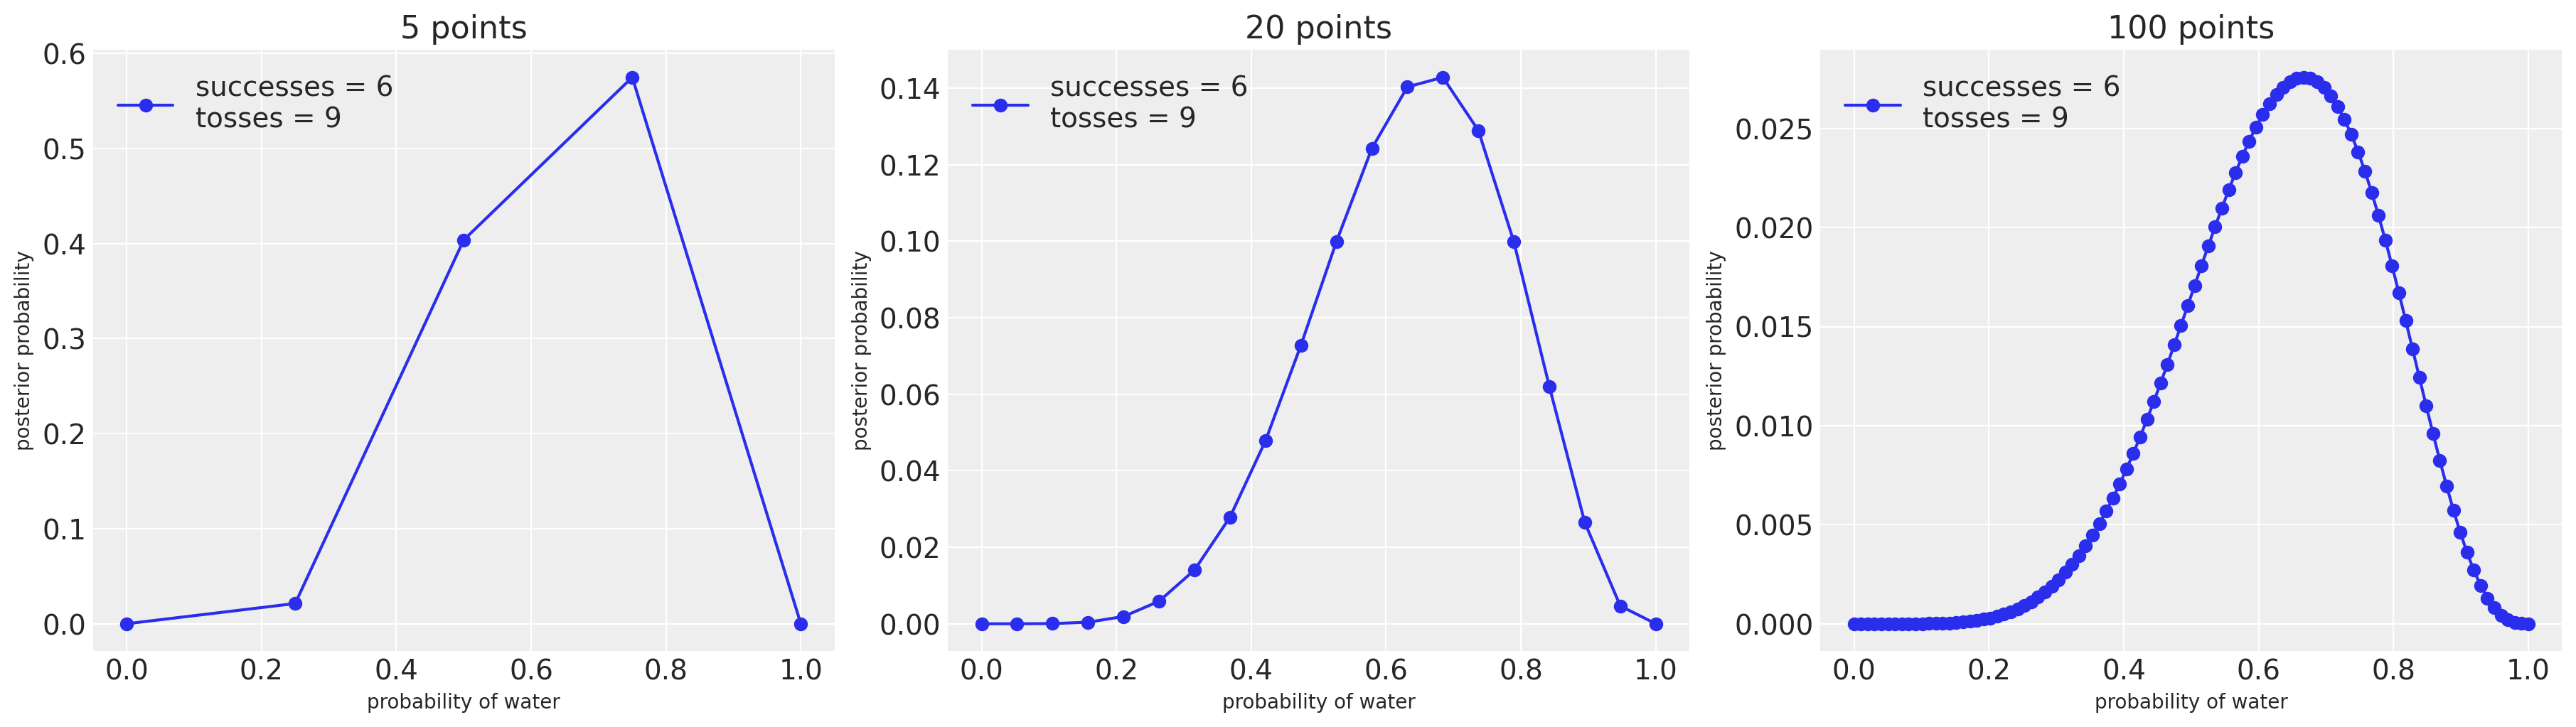

In [8]:
w, n = 6, 9

points = (5, 20, 100)

_, ax = plt.subplots(1, len(points), figsize=(6 * len(points), 5))
for idx, ps in enumerate(points):
    p_grid, posterior = binom_post_grid_approx(uniform_prior, ps, w, n)
    ax[idx].plot(p_grid, posterior, "o-", label=f"successes = {w}\ntosses = {n}")
    ax[idx].set_xlabel("probability of water")
    ax[idx].set_ylabel("posterior probability")
    ax[idx].set_title(f"{ps} points")
    ax[idx].legend(loc=0)

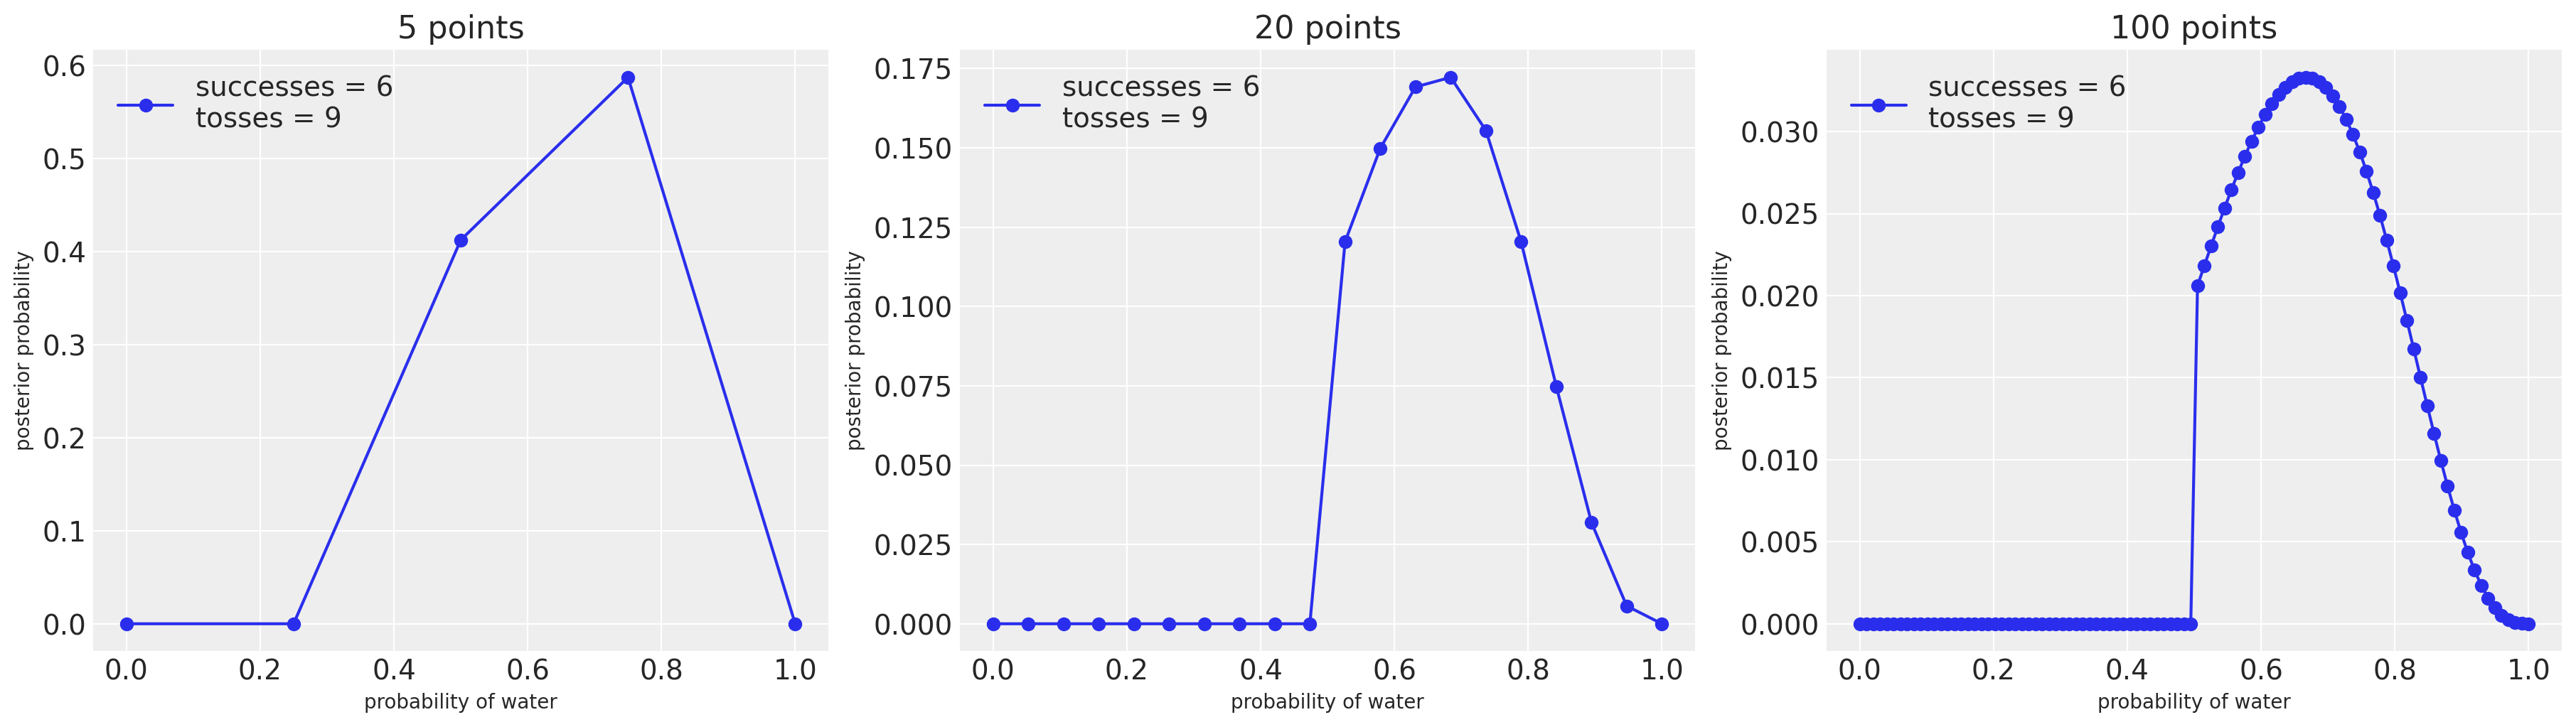

In [9]:
_, ax = plt.subplots(1, len(points), figsize=(6 * len(points), 5))
for idx, ps in enumerate(points):
    p_grid, posterior = binom_post_grid_approx(truncated_prior, ps, w, n)
    ax[idx].plot(p_grid, posterior, "o-", label=f"successes = {w}\ntosses = {n}")
    ax[idx].set_xlabel("probability of water")
    ax[idx].set_ylabel("posterior probability")
    ax[idx].set_title(f"{ps} points")
    ax[idx].legend(loc=0)

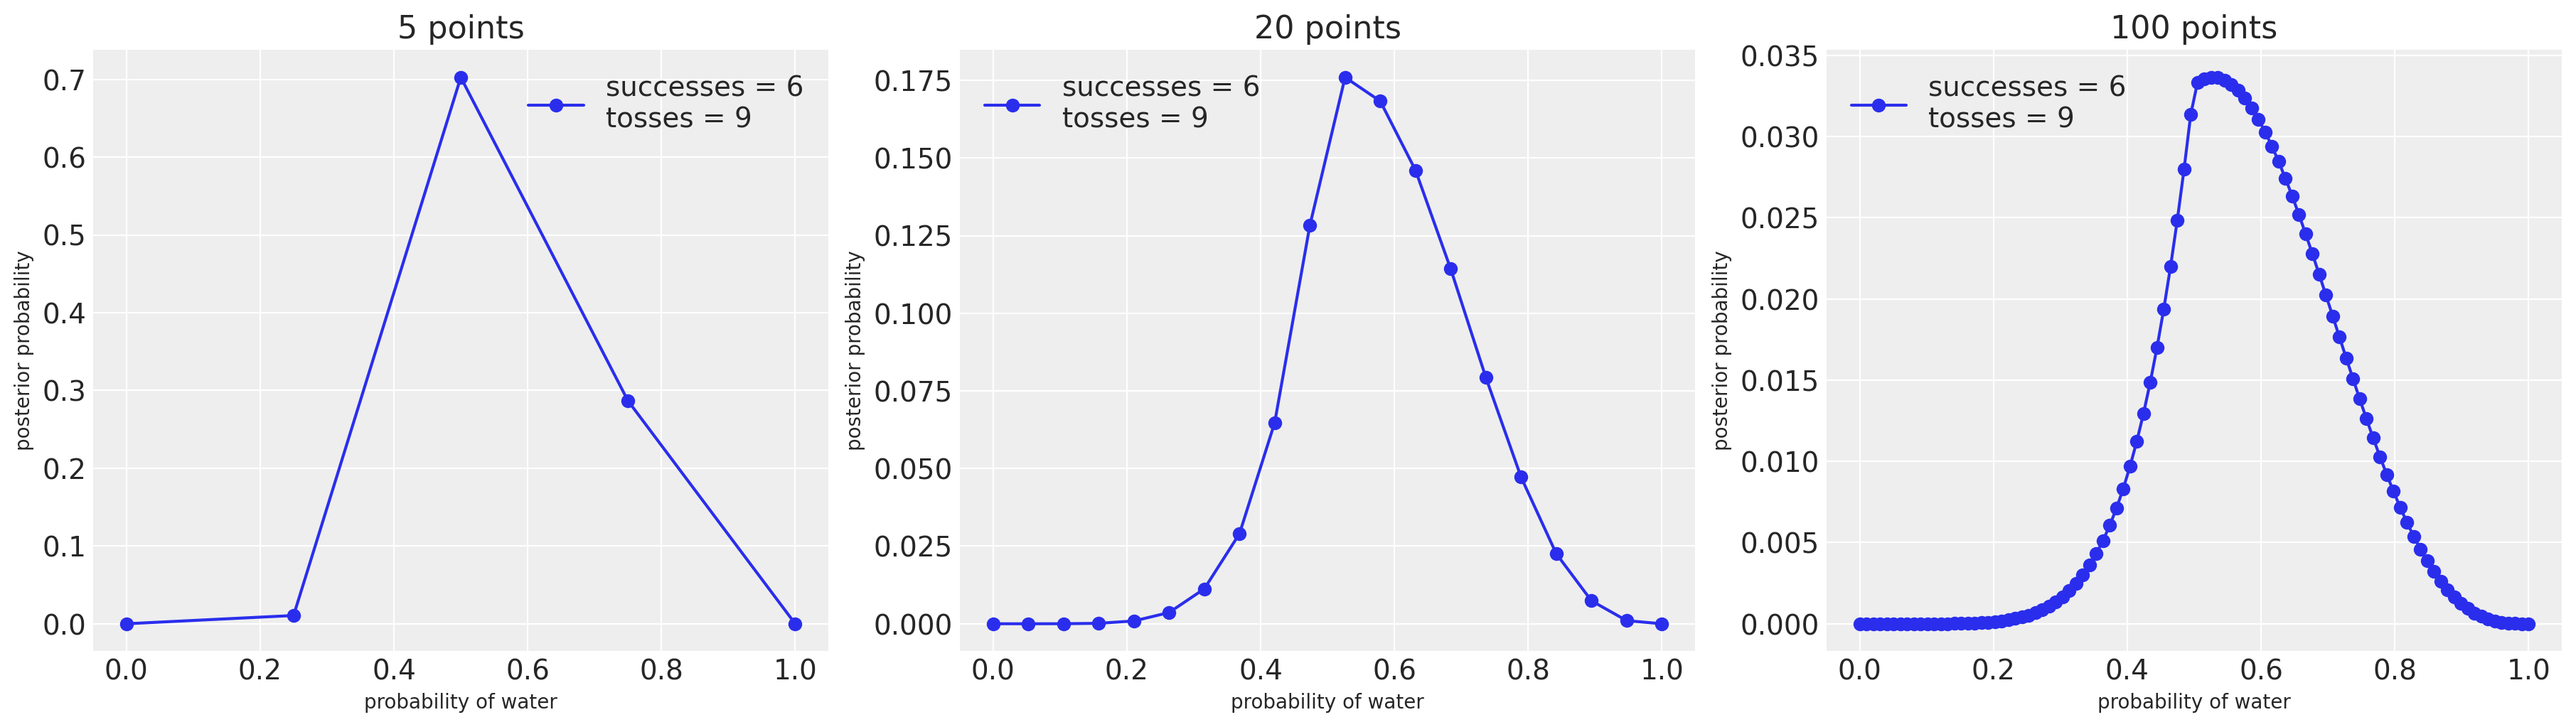

In [10]:
_, ax = plt.subplots(1, len(points), figsize=(6 * len(points), 5))
for idx, ps in enumerate(points):
    p_grid, posterior = binom_post_grid_approx(double_exp_prior, ps, w, n)
    ax[idx].plot(p_grid, posterior, "o-", label=f"successes = {w}\ntosses = {n}")
    ax[idx].set_xlabel("probability of water")
    ax[idx].set_ylabel("posterior probability")
    ax[idx].set_title(f"{ps} points")
    ax[idx].legend(loc=0)

#### Code 2.6

Computing the posterior using the quadratic approximation (quad).

In [12]:
np.repeat((0, 1), (3, 6))

array([0, 0, 0, 1, 1, 1, 1, 1, 1])

In [13]:
data = np.repeat((0, 1), (3, 6))
with pm.Model() as normal_approximation:
    p = pm.Uniform("p", 0, 1)  # uniform priors
    w = pm.Binomial("w", n=len(data), p=p, observed=data.sum())  # binomial likelihood
    mean_q = pm.find_MAP()

    p_value = normal_approximation.rvs_to_values[p]
    p_value.tag.transform = None
    p_value.name = p.name

    std_q = ((1 / pm.find_hessian(mean_q, vars=[p])) ** 0.5)[0]

# display summary of quadratic approximation
print("Mean, Standard deviation\np {:.2}, {:.2}".format(mean_q["p"], std_q[0]))


Mean, Standard deviation
p 0.67, 0.64


In [14]:
# Compute the 89% percentile interval
norm = stats.norm(mean_q, std_q)
prob = 0.89
z = stats.norm.ppf([(1 - prob) / 2, (1 + prob) / 2])
pi = mean_q["p"] + std_q * z
print("5.5%, 94.5% \n{:.2}, {:.2}".format(pi[0], pi[1]))

5.5%, 94.5% 
-0.35, 1.7


#### Code 2.7

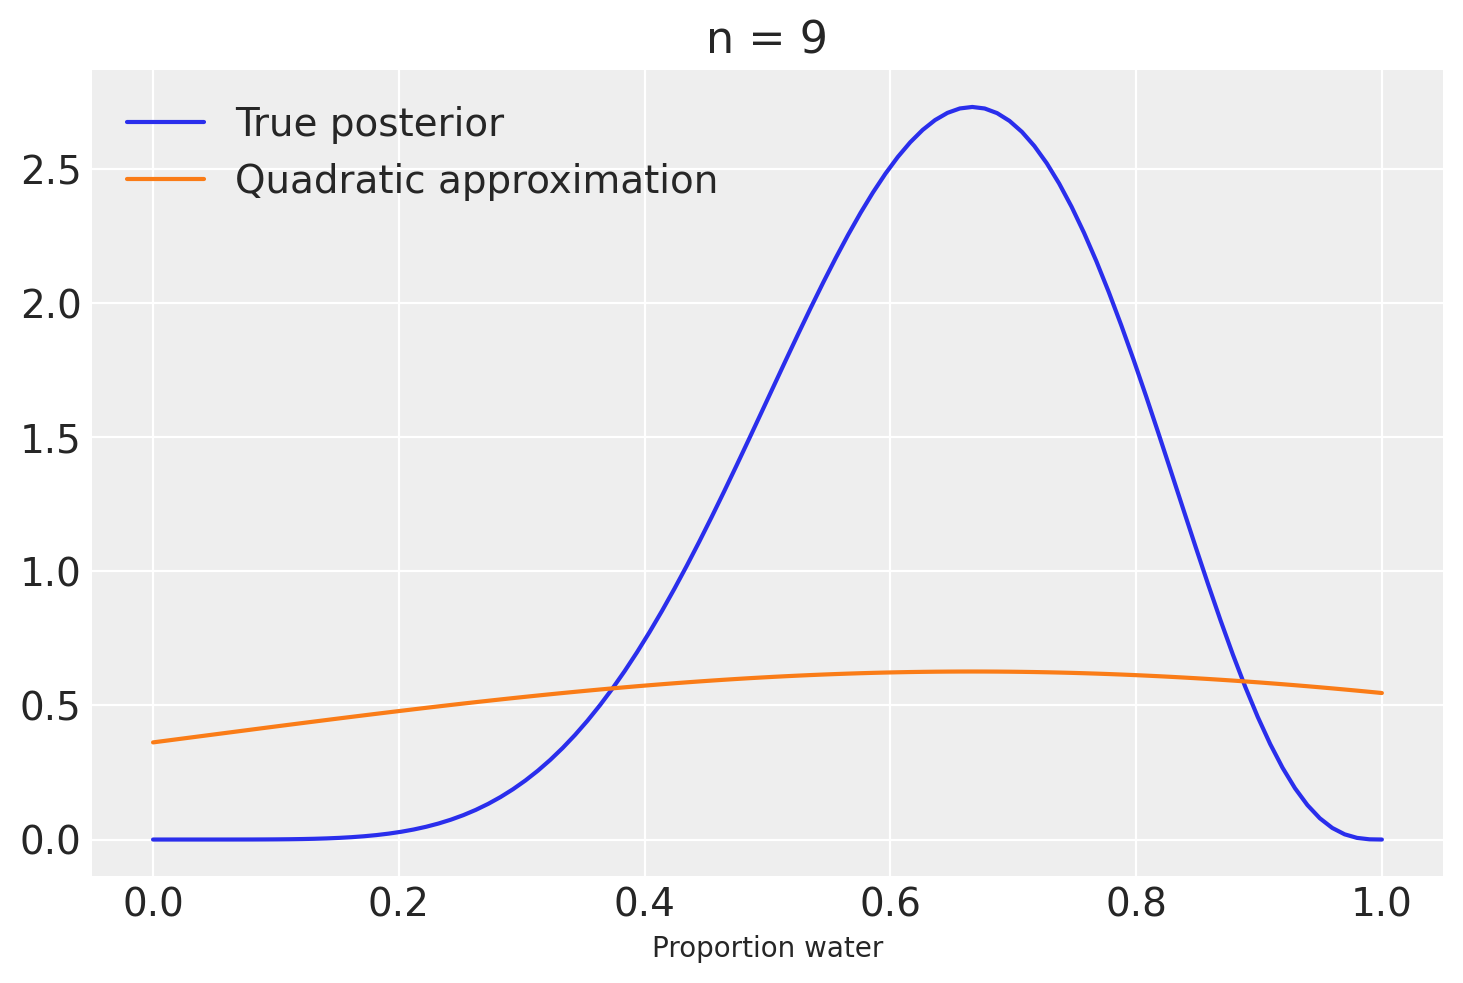

In [15]:
# analytical calculation
w, n = 6, 9
x = np.linspace(0, 1, 100)
plt.plot(x, stats.beta.pdf(x, w + 1, n - w + 1), label="True posterior")

# quadratic approximation
plt.plot(x, stats.norm.pdf(x, mean_q["p"], std_q), label="Quadratic approximation")
plt.legend(loc=0)

plt.title(f"n = {n}")
plt.xlabel("Proportion water");

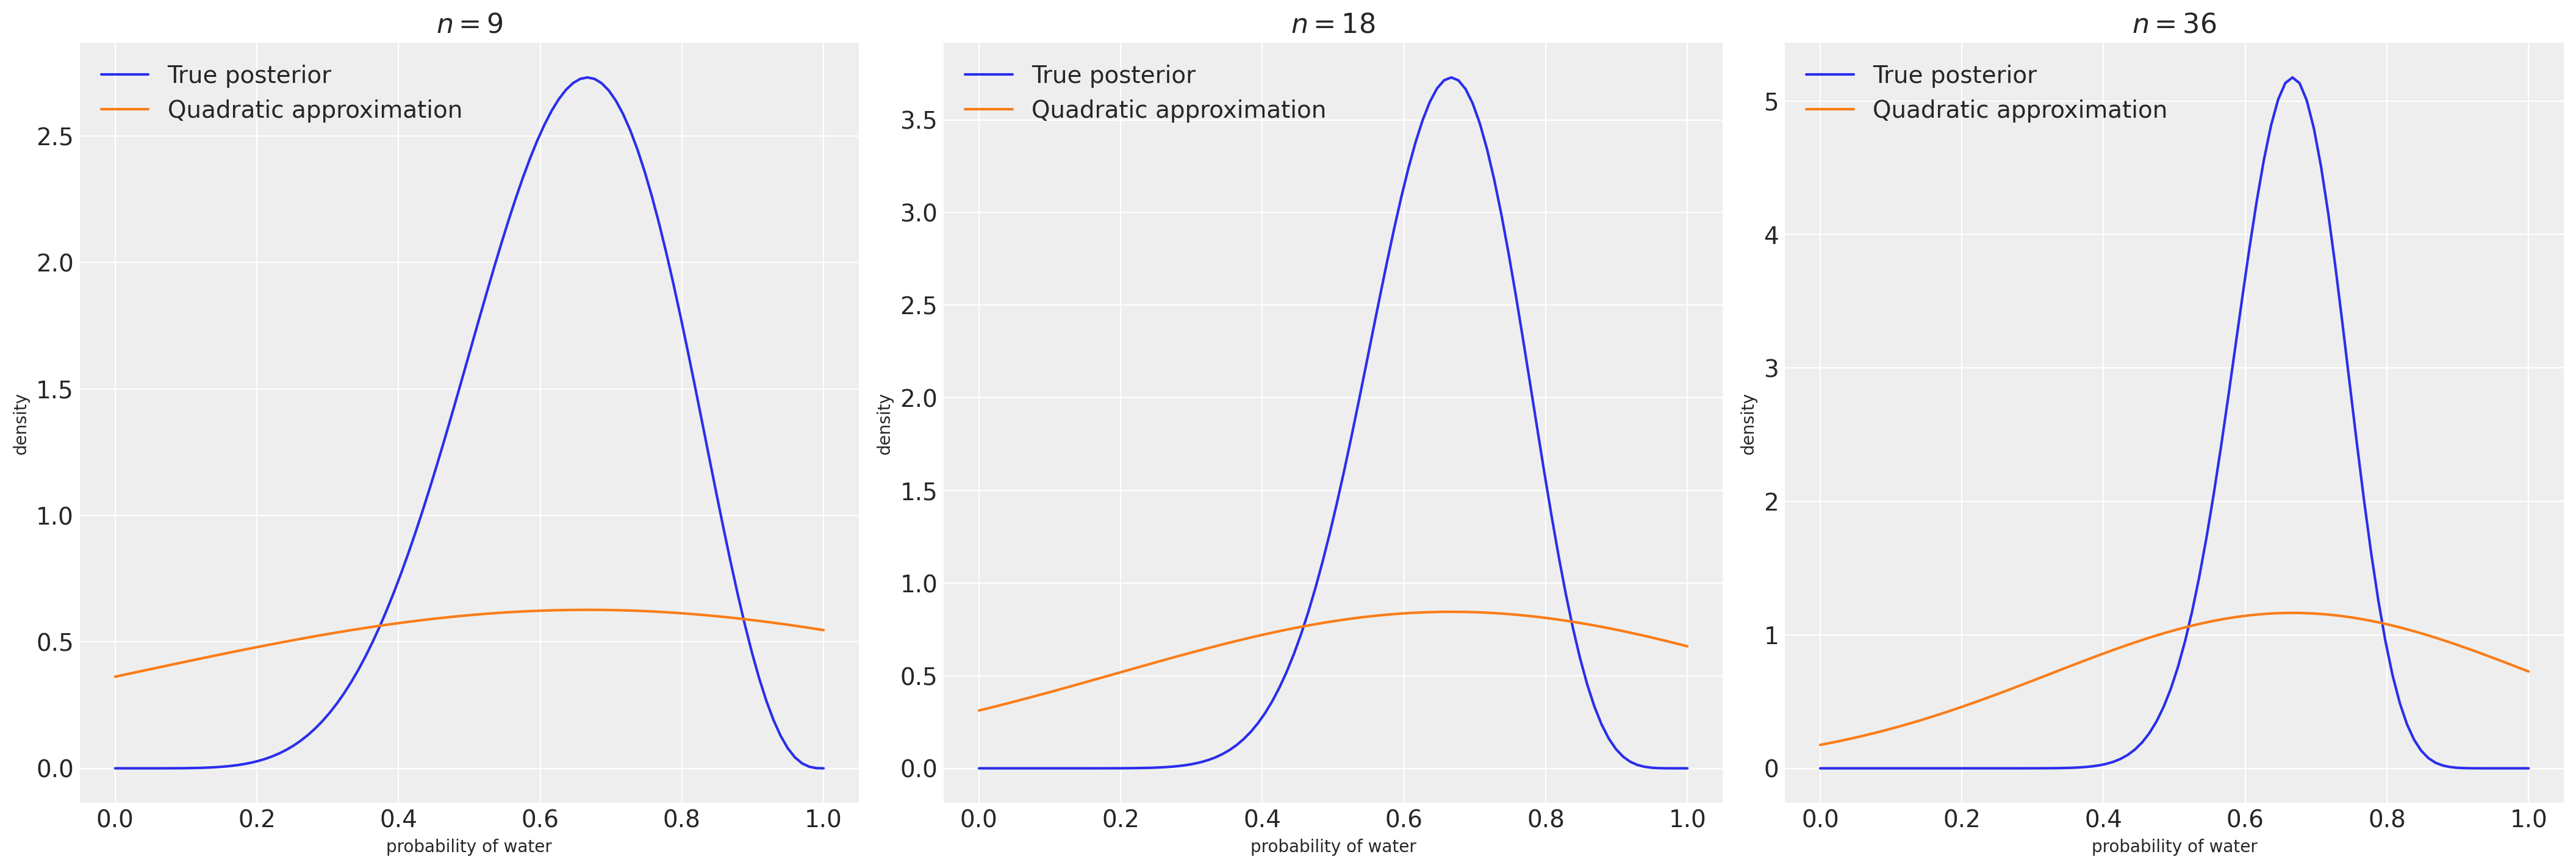

In [16]:
# Figure 2.8
x = np.linspace(0, 1, 100)
w, n = [6, 12, 24], [9, 18, 36]

fig, ax = plt.subplots(1, 3, figsize=(21, 7))

for idx, ps in enumerate(zip(w, n)):
    data = np.repeat((0, 1), (ps[1] - ps[0], ps[0]))
    with pm.Model() as normal_approximation:
        p = pm.Uniform("p", 0, 1)  # uniform priors
        w = pm.Binomial("w", n=len(data), p=p, observed=data.sum())  # binomial likelihood
        mean_q = pm.find_MAP()

        p_value = normal_approximation.rvs_to_values[p]
        p_value.tag.transform = None
        p_value.name = p.name

        std_q = ((1 / pm.find_hessian(mean_q, vars=[p])) ** 0.5)[0]

    ax[idx].plot(x, stats.beta.pdf(x, ps[0] + 1, ps[1] - ps[0] + 1), label="True posterior")
    ax[idx].plot(x, stats.norm.pdf(x, mean_q["p"], std_q), label="Quadratic approximation")
    ax[idx].set_xlabel("probability of water")
    ax[idx].set_ylabel("density")
    ax[idx].set_title(r"$n={}$".format(ps[1]))
    ax[idx].legend(loc="upper left")

#### Code 2.8

In [17]:
n_samples = 1000
p = np.zeros(n_samples)
p[0] = 0.5
W = 6
L = 3
for i in range(1, n_samples):
    p_new = stats.norm(p[i - 1], 0.1).rvs(1)
    if p_new < 0:
        p_new = -p_new
    if p_new > 1:
        p_new = 2 - p_new
    q0 = stats.binom.pmf(W, n=W + L, p=p[i - 1])
    q1 = stats.binom.pmf(W, n=W + L, p=p_new)
    if stats.uniform.rvs(0, 1) < q1 / q0:
        p[i] = p_new
    else:
        p[i] = p[i - 1]

/opt/anaconda3/lib/python3.8/site-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


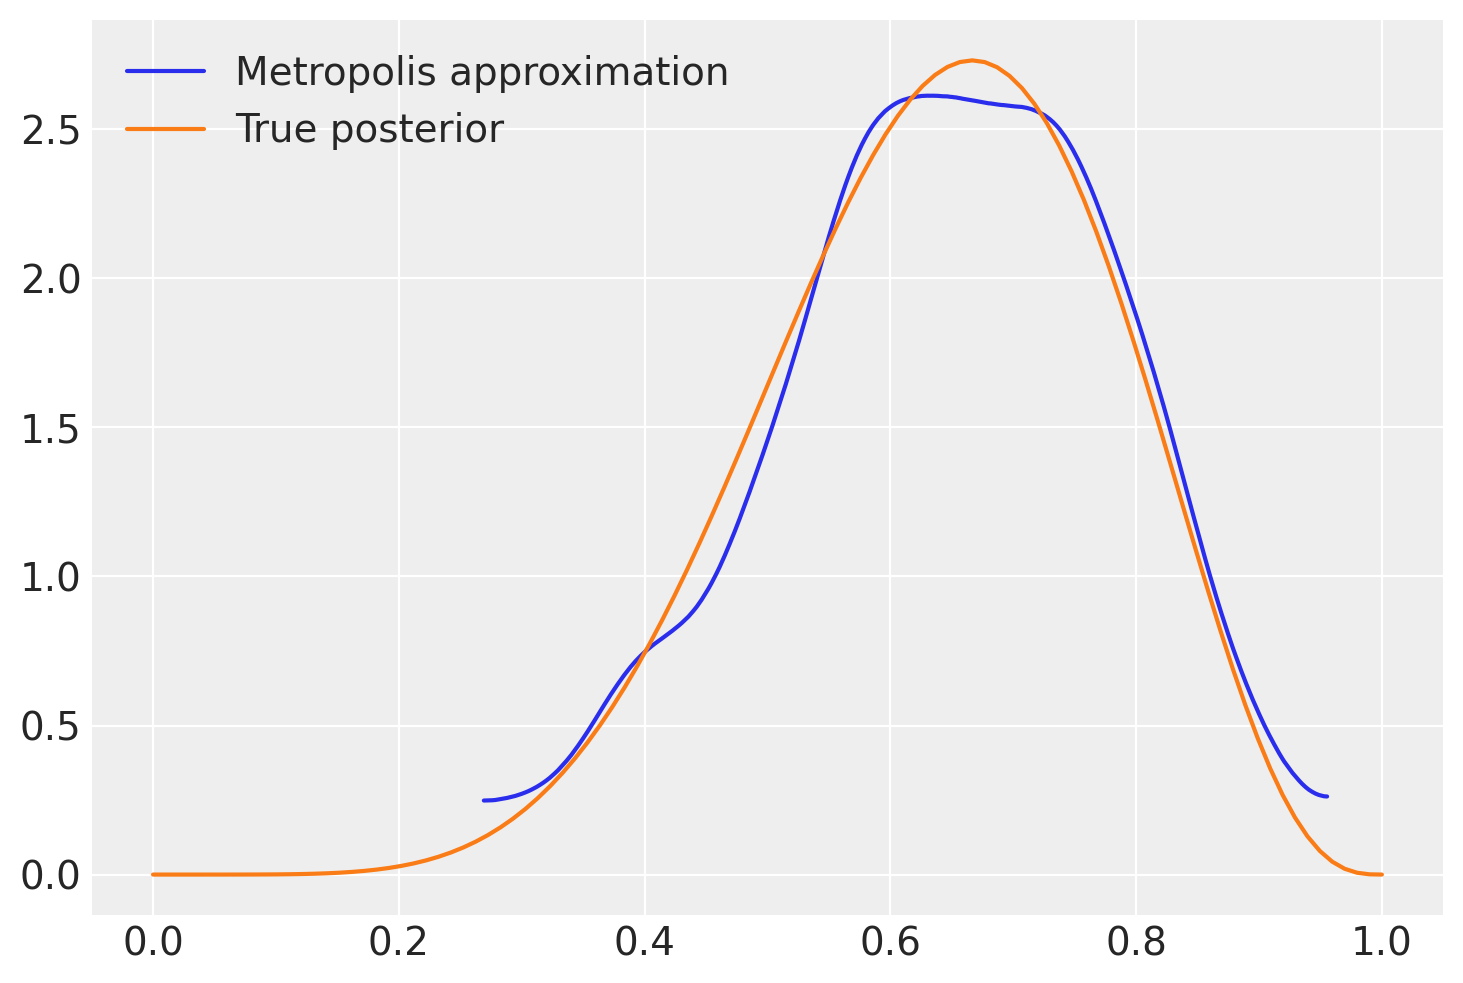

In [18]:
az.plot_kde(p, label="Metropolis approximation")
x = np.linspace(0, 1, 100)
plt.plot(x, stats.beta.pdf(x, W + 1, L + 1), "C1", label="True posterior")
plt.legend();

# 2E1.

Which of the expressions below correspond to the statement: the probability of rain on Monday?

1. Pr(rain)
2. Pr(rain|Monday)
3. Pr(Monday|rain)
4. Pr(rain,Monday)/Pr(Monday)

**Answer:** 2 and 4

# 2E2.

Which of the following statements corresponds to the expression: Pr(Monday|rain)?

1. The probability of rain on Monday.
2. The probability of rain, given that it is Monday.
3. The probability that it is Monday, given that it is raining.
4. The probability that it is Monday and that it is raining.

**Answer:** 3

# 2E3.

2E3. Which of the expressions below correspond to the statement: the probability that it is Monday,
given that it is raining?

1. Pr(Monday|rain)
2. Pr(rain|Monday)
3. Pr(rain|Monday)Pr(Monday)
4. Pr(rain|Monday)Pr(Monday)/Pr(rain)
5. Pr(Monday|rain)Pr(rain)/Pr(Monday

**Answer:** 1 and 4